<a href="https://colab.research.google.com/github/Ariepramudya01/Classification-Clustering-of-Mature-Papaya/blob/main/AQI_Forecast_Using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import shutil
import zipfile
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import LabelEncoder


In [2]:
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Create the destination directory if it doesn't exist

os.makedirs('/root/.kaggle/', exist_ok=True)

# Now copy the file
shutil.copy('/content/drive/MyDrive/Regresi Harga Mobil/kaggle.json', '/root/.kaggle/kaggle.json')

'/root/.kaggle/kaggle.json'

In [4]:
!kaggle datasets download -d azminetoushikwasi/aqi-air-quality-index-scheduled-daily-update

Dataset URL: https://www.kaggle.com/datasets/azminetoushikwasi/aqi-air-quality-index-scheduled-daily-update
License(s): ODbL-1.0
aqi-air-quality-index-scheduled-daily-update.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
# Extract the zip file
zip_ref = zipfile.ZipFile('/content/aqi-air-quality-index-scheduled-daily-update.zip', 'r')
zip_ref.extractall('/content/aqi-air-quality-index-scheduled-daily-update')
zip_ref.close()

In [6]:
# Assuming your extracted data is in a CSV file, replace 'your_file.csv' with the actual file name
df = pd.read_csv('/content/aqi-air-quality-index-scheduled-daily-update/data_date.csv')

# Display basic information about the dataset
print(df.info())

# Show the first few rows of the data
print(df.head())

# Describe the numerical features of the dataset
print(df.describe())

# You can also explore specific columns or perform other analyses based on your needs
# For example, to see the unique values in a column:
# print(df['column_name'].unique())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15065 entries, 0 to 15064
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       15065 non-null  object
 1   Country    15065 non-null  object
 2   Status     15065 non-null  object
 3   AQI Value  15065 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 470.9+ KB
None
         Date    Country                          Status  AQI Value
0  2022-07-21    Albania                            Good         14
1  2022-07-21    Algeria                        Moderate         65
2  2022-07-21    Andorra                        Moderate         55
3  2022-07-21     Angola  Unhealthy for Sensitive Groups        113
4  2022-07-21  Argentina                        Moderate         63
          AQI Value
count  15065.000000
mean      61.786193
std       48.576105
min        1.000000
25%       29.000000
50%       52.000000
75%       81.000000
max      963.000000


In [7]:
df.head()

,Date,Country,Status,AQI Value
0,2022-07-21,Albania,Good,14
1,2022-07-21,Algeria,Moderate,65
2,2022-07-21,Andorra,Moderate,55
3,2022-07-21,Angola,Unhealthy for Sensitive Groups,113
4,2022-07-21,Argentina,Moderate,63


In [8]:
# Check for missing values in the DataFrame
missing_values = df.isnull().sum()

# Print the count of missing values for each column
print(missing_values)


Date         0
Country      0
Status       0
AQI Value    0
dtype: int64


In [9]:
# Inisialisasi LabelEncoder
le = LabelEncoder()

# Ubah kolom 'status' menjadi tipe data kategori angka
df['Status'] = le.fit_transform(df['Status'])

# Tampilkan beberapa baris pertama DataFrame untuk memeriksa perubahan
print(df.head())


         Date    Country  Status  AQI Value
0  2022-07-21    Albania       0         14
1  2022-07-21    Algeria       2         65
2  2022-07-21    Andorra       2         55
3  2022-07-21     Angola       4        113
4  2022-07-21  Argentina       2         63


In [10]:
# Inisialisasi LabelEncoder
le = LabelEncoder()

# Ubah kolom 'Country' menjadi tipe data kategori angka
df['Country'] = le.fit_transform(df['Country'])

# Tampilkan beberapa baris pertama DataFrame untuk memeriksa perubahan
print(df.head())


         Date  Country  Status  AQI Value
0  2022-07-21        0       0         14
1  2022-07-21        1       2         65
2  2022-07-21        2       2         55
3  2022-07-21        3       4        113
4  2022-07-21        4       2         63


In [11]:
# Convert the 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'])

# Extract year, month, and day as separate features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

# You can also extract other time-related features like day of the week, quarter, etc.
# df['DayOfWeek'] = df['Date'].dt.dayofweek
# df['Quarter'] = df['Date'].dt.quarter

# Optionally, you can drop the original 'Date' column if you don't need it anymore
# df = df.drop('Date', axis=1)

print(df.head())


        Date  Country  Status  AQI Value  Year  Month  Day
0 2022-07-21        0       0         14  2022      7   21
1 2022-07-21        1       2         65  2022      7   21
2 2022-07-21        2       2         55  2022      7   21
3 2022-07-21        3       4        113  2022      7   21
4 2022-07-21        4       2         63  2022      7   21


In [12]:
numerical_cols = df.select_dtypes(include=['number', 'category']).columns
df_numerical = df[numerical_cols]
print(df_numerical.head())


   Country  Status  AQI Value  Year  Month  Day
0        0       0         14  2022      7   21
1        1       2         65  2022      7   21
2        2       2         55  2022      7   21
3        3       4        113  2022      7   21
4        4       2         63  2022      7   21


In [13]:
# Inisialisasi MinMaxScaler
scaler = MinMaxScaler()

# Normalisasi data numerik
df_normalized = pd.DataFrame(scaler.fit_transform(df_numerical), columns=df_numerical.columns)

# Tampilkan beberapa baris pertama DataFrame yang sudah dinormalisasi
print(df_normalized.head())


    Country  Status  AQI Value  Year  Month       Day
0  0.000000     0.0   0.013514   0.0   0.75  0.666667
1  0.007092     0.4   0.066528   0.0   0.75  0.666667
2  0.014184     0.4   0.056133   0.0   0.75  0.666667
3  0.021277     0.8   0.116424   0.0   0.75  0.666667
4  0.028369     0.4   0.064449   0.0   0.75  0.666667


In [14]:
# Pisahkan fitur (X) dan target (y) - sesuaikan dengan kolom target Anda
X = df_normalized.drop('AQI Value', axis=1)  # Ganti 'AQI' dengan nama kolom target Anda
y = df_normalized['AQI Value']

# Pembagian data 90:10
X_train_90, X_test_90, y_train_90, y_test_90 = train_test_split(X, y, test_size=0.1, random_state=42)

# Pembagian data 80:20
X_train_80, X_test_80, y_train_80, y_test_80 = train_test_split(X, y, test_size=0.2, random_state=42)

# Pembagian data 70:30
X_train_70, X_test_70, y_train_70, y_test_70 = train_test_split(X, y, test_size=0.3, random_state=42)

# Cetak ukuran data training dan testing untuk setiap pembagian
print("Pembagian 90:10:")
print("Ukuran data training:", X_train_90.shape, y_train_90.shape)
print("Ukuran data testing:", X_test_90.shape, y_test_90.shape)

print("\nPembagian 80:20:")
print("Ukuran data training:", X_train_80.shape, y_train_80.shape)
print("Ukuran data testing:", X_test_80.shape, y_test_80.shape)

print("\nPembagian 70:30:")
print("Ukuran data training:", X_train_70.shape, y_train_70.shape)
print("Ukuran data testing:", X_test_70.shape, y_test_70.shape)


Pembagian 90:10:
Ukuran data training: (13558, 5) (13558,)
Ukuran data testing: (1507, 5) (1507,)

Pembagian 80:20:
Ukuran data training: (12052, 5) (12052,)
Ukuran data testing: (3013, 5) (3013,)

Pembagian 70:30:
Ukuran data training: (10545, 5) (10545,)
Ukuran data testing: (4520, 5) (4520,)


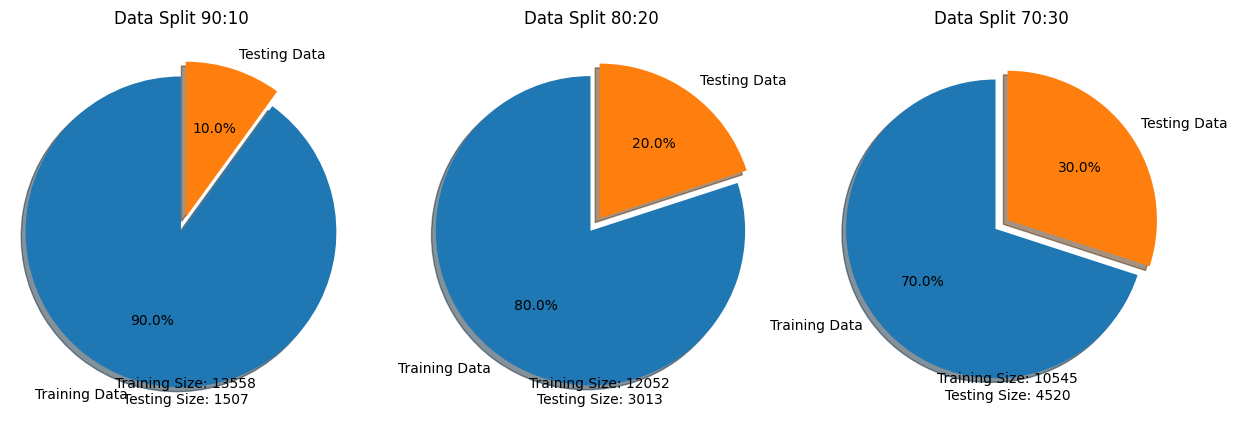

In [15]:
# Data untuk visualisasi
data_sizes = [
    (X_train_90.shape[0], X_test_90.shape[0]),
    (X_train_80.shape[0], X_test_80.shape[0]),
    (X_train_70.shape[0], X_test_70.shape[0])
]
ratios = ['90:10', '80:20', '70:30']

# Membuat plot pie chart
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, (train_size, test_size) in enumerate(data_sizes):
  sizes = [train_size, test_size]
  labels = ['Training Data', 'Testing Data']
  explode = (0.1, 0)  # Explode the 1st slice (Training Data)

  axes[i].pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
  axes[i].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
  axes[i].set_title(f'Data Split {ratios[i]}')
  axes[i].text(0, -1.2, f'Training Size: {train_size}\nTesting Size: {test_size}', ha='center')

plt.show()


In [16]:
def train_model_with_eta(X_train, y_train, X_test, y_test, ratio):
    start_time = time.time()

    for iteration in range(10):
        print(f"\nIterasi ke-{iteration + 1} dengan rasio {ratio}:")

        # Inisialisasi model LSTM
        model = Sequential()
        model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
        model.add(LSTM(units=50))
        model.add(Dense(units=1))

        # Kompilasi model
        model.compile(optimizer='adam', loss='mean_squared_error')

        # Menampilkan summary model
        print("Summary Model:")
        model.summary()

        # Melatih model
        history = model.fit(X_train, y_train, epochs=50, batch_size=32,
                            validation_data=(X_test, y_test), verbose=1)

        # Menghitung waktu yang telah berlalu dan perkiraan waktu yang tersisa
        elapsed_time = time.time() - start_time
        remaining_time = (elapsed_time / (iteration + 1)) * (10 - (iteration + 1))
        print(f"ETA: {remaining_time:.2f} detik")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 5, 50)               │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Melatih model dengan rasio data yang berbeda
train_model_with_eta(X_train_90, y_train_90, X_test_90, y_test_90, '90:10')
train_model_with_eta(X_train_80, y_train_80, X_test_80, y_test_80, '80:20')
train_model_with_eta(X_train_70, y_train_70, X_test_70, y_test_70, '70:30')



Iterasi ke-1 dengan rasio 90:10:
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


424/424 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 2/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 3/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 4/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 5/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 6/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 7/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 8/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 9/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 10/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 9.7932e-04 - val_loss: 0.0013
Epoch 11/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 12/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


424/424 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 2/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 3/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 4/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 9.8744e-04 - val_loss: 0.0013
Epoch 5/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 6/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 9.8694e-04 - val_loss: 0.0013
Epoch 7/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 8/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 9.9323e-04 - val_loss: 0.0013
Epoch 9/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 10/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 11/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 12/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 4s 9m

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


424/424 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 2/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 3/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 4/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 5/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 6/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 7/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 8/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 9/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 10/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 11/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 12/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - los

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


424/424 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 2/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 3/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 4/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 9.8266e-04 - val_loss: 0.0016
Epoch 5/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 6/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 7/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 8/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 9/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 10/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 9.1458e-04 - val_loss: 0.0015
Epoch 11/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 12/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/st

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


424/424 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 2/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 3/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 4/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 5/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0010 - val_loss: 0.0015
Epoch 6/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 9.7807e-04 - val_loss: 0.0014
Epoch 7/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 8/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 9/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 10/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 11/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 8.7916e-04 - val_loss: 0.0013
Epoch 12/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/s

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


424/424 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 2/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 3/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 4/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 5/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 9.8692e-04 - val_loss: 0.0013
Epoch 6/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 9.9388e-04 - val_loss: 0.0013
Epoch 7/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 8/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 9.0780e-04 - val_loss: 0.0013
Epoch 9/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 10/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 11/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 9.8689e-04 - val_loss: 0.0013
Epoch 12/50
424/424 ━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


424/424 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 2/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 3/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 4/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 5/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 6/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 7/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 8/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 9/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 10/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 11/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 12/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - los

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


424/424 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.0028 - val_loss: 0.0022
Epoch 2/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 3/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 4/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 5/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 6/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 7/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 8/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 9.3932e-04 - val_loss: 0.0013
Epoch 9/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 9.4867e-04 - val_loss: 0.0013
Epoch 10/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 11/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 12/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/st

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


424/424 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 2/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 3/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 4/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 5/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 6/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 7/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 8/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 9.9918e-04 - val_loss: 0.0013
Epoch 9/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 10/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 9.9772e-04 - val_loss: 0.0013
Epoch 11/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 12/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/st

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 2/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 3/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 4/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 9.9905e-04 - val_loss: 0.0013
Epoch 5/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 6/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 9.6539e-04 - val_loss: 0.0013
Epoch 7/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 8/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 9/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 10/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 11/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 9.6541e-04 - val_loss: 0.0013
Epoch 12/50
424/424 ━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


377/377 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 2/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 3/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0017 - val_loss: 9.7105e-04
Epoch 4/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0011 - val_loss: 9.5503e-04
Epoch 5/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 6/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 7/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0012 - val_loss: 9.2856e-04
Epoch 8/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 9.3435e-04 - val_loss: 0.0011
Epoch 9/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 9.2977e-04 - val_loss: 9.2327e-04
Epoch 10/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0013 - val_loss: 9.2492e-04
Epoch 11/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0010 - val_loss: 9.1901e-04
Epoch 12/50
377/377 ━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


377/377 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 2/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 3/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0013 - val_loss: 9.8898e-04
Epoch 4/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0013 - val_loss: 9.3730e-04
Epoch 5/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0013 - val_loss: 9.2841e-04
Epoch 6/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0012 - val_loss: 9.3260e-04
Epoch 7/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0011 - val_loss: 9.4894e-04
Epoch 8/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0011 - val_loss: 9.2861e-04
Epoch 9/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0012 - val_loss: 9.7406e-04
Epoch 10/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0010 - val_loss: 9.6275e-04
Epoch 11/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 9.5591e-04 - val_loss: 0.0010
Epoch 12/50
377/377 ━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


377/377 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 2/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 3/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 4/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0012 - val_loss: 9.9907e-04
Epoch 5/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 6/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0013 - val_loss: 9.3721e-04
Epoch 7/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0011 - val_loss: 9.3573e-04
Epoch 8/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0011 - val_loss: 9.2699e-04
Epoch 9/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0011 - val_loss: 9.7763e-04
Epoch 10/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 9.4549e-04 - val_loss: 9.5668e-04
Epoch 11/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 9.6374e-04 - val_loss: 9.6916e-04
Epoch 12/50
377/377 ━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


377/377 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 2/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 3/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0012 - val_loss: 9.6084e-04
Epoch 4/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0010 - val_loss: 9.4719e-04
Epoch 5/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0011 - val_loss: 9.4373e-04
Epoch 6/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0011 - val_loss: 9.4957e-04
Epoch 7/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0012 - val_loss: 9.5021e-04
Epoch 8/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0012 - val_loss: 9.3308e-04
Epoch 9/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0010 - val_loss: 9.5426e-04
Epoch 10/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0012 - val_loss: 9.4153e-04
Epoch 11/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0011 - val_loss: 9.3387e-04
Epoch 12/50
377/377 ━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


377/377 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 2/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 3/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0017 - val_loss: 9.5897e-04
Epoch 4/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0012 - val_loss: 9.5256e-04
Epoch 5/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 6/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0011 - val_loss: 9.3493e-04
Epoch 7/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0010 - val_loss: 9.4459e-04
Epoch 8/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0011 - val_loss: 9.4330e-04
Epoch 9/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0010 - val_loss: 9.3046e-04
Epoch 10/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 9.5111e-04 - val_loss: 9.6882e-04
Epoch 11/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0011 - val_loss: 9.4394e-04
Epoch 12/50
377/377 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


377/377 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 2/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 3/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0012 - val_loss: 9.7642e-04
Epoch 4/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0012 - val_loss: 9.5527e-04
Epoch 5/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0011 - val_loss: 9.5340e-04
Epoch 6/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 9.6468e-04 - val_loss: 9.5510e-04
Epoch 7/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0011 - val_loss: 9.3755e-04
Epoch 8/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0011 - val_loss: 9.4987e-04
Epoch 9/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0011 - val_loss: 9.2745e-04
Epoch 10/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0012 - val_loss: 9.2943e-04
Epoch 11/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0011 - val_loss: 9.2585e-04
Epoch 12/50
3

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


377/377 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 2/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 3/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0014 - val_loss: 9.8946e-04
Epoch 4/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 5/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0013 - val_loss: 9.2956e-04
Epoch 6/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0012 - val_loss: 9.5761e-04
Epoch 7/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 9.4309e-04 - val_loss: 9.3078e-04
Epoch 8/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0011 - val_loss: 9.2962e-04
Epoch 9/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0011 - val_loss: 9.6225e-04
Epoch 10/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0011 - val_loss: 9.2694e-04
Epoch 11/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0011 - val_loss: 9.2682e-04
Epoch 12/50
377/377 ━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


377/377 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 2/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 3/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0017 - val_loss: 9.9320e-04
Epoch 4/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0012 - val_loss: 9.4402e-04
Epoch 5/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0012 - val_loss: 9.8155e-04
Epoch 6/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 7/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 8/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 9.8399e-04 - val_loss: 9.7285e-04
Epoch 9/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0010 - val_loss: 9.5928e-04
Epoch 10/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0014 - val_loss: 9.3075e-04
Epoch 11/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0012 - val_loss: 9.4728e-04
Epoch 12/50
377/377 ━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


377/377 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 2/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 3/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 4/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0015 - val_loss: 9.5489e-04
Epoch 5/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 9.8156e-04 - val_loss: 9.4374e-04
Epoch 6/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 9.6599e-04 - val_loss: 9.7627e-04
Epoch 7/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0012 - val_loss: 9.4524e-04
Epoch 8/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0011 - val_loss: 9.2958e-04
Epoch 9/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0012 - val_loss: 9.2216e-04
Epoch 10/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 9.9362e-04 - val_loss: 9.3302e-04
Epoch 11/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0014 - val_loss: 9.4611e-04
Epoch 12/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


377/377 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 2/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 3/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 4/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0011 - val_loss: 9.7690e-04
Epoch 5/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0013 - val_loss: 9.3141e-04
Epoch 6/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0010 - val_loss: 9.3337e-04
Epoch 7/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0012 - val_loss: 9.3064e-04
Epoch 8/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0010 - val_loss: 9.2700e-04
Epoch 9/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0011 - val_loss: 9.2135e-04
Epoch 10/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0011 - val_loss: 9.2635e-04
Epoch 11/50
377/377 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0010 - val_loss: 9.8487e-04
Epoch 12/50
377/377 ━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


330/330 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0026 - val_loss: 0.0019
Epoch 2/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 3/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 4/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 5/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0010 - val_loss: 9.3359e-04
Epoch 6/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0017 - val_loss: 9.2339e-04
Epoch 7/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0014 - val_loss: 9.1052e-04
Epoch 8/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0013 - val_loss: 9.0327e-04
Epoch 9/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0013 - val_loss: 9.0280e-04
Epoch 10/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0012 - val_loss: 9.3126e-04
Epoch 11/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0012 - val_loss: 8.9183e-04
Epoch 12/50
330/330 ━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


330/330 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 2/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 3/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 4/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0013 - val_loss: 9.3068e-04
Epoch 5/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0013 - val_loss: 9.5572e-04
Epoch 6/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0014 - val_loss: 9.0449e-04
Epoch 7/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0011 - val_loss: 9.1736e-04
Epoch 8/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 9/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0012 - val_loss: 9.1622e-04
Epoch 10/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0011 - val_loss: 9.0441e-04
Epoch 11/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0011 - val_loss: 9.0566e-04
Epoch 12/50
330/330 ━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


330/330 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 2/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 3/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0018 - val_loss: 9.9442e-04
Epoch 4/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0015 - val_loss: 9.1685e-04
Epoch 5/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0011 - val_loss: 9.0455e-04
Epoch 6/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0011 - val_loss: 9.2670e-04
Epoch 7/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0013 - val_loss: 9.2733e-04
Epoch 8/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0011 - val_loss: 9.0151e-04
Epoch 9/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0010 - val_loss: 8.9586e-04
Epoch 10/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0010 - val_loss: 9.0063e-04
Epoch 11/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0010 - val_loss: 8.9476e-04
Epoch 12/50
330/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


330/330 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 2/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 3/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0016 - val_loss: 9.6774e-04
Epoch 4/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0016 - val_loss: 9.2371e-04
Epoch 5/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0010 - val_loss: 9.1899e-04
Epoch 6/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0014 - val_loss: 9.1114e-04
Epoch 7/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0012 - val_loss: 9.0140e-04
Epoch 8/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 9.9585e-04 - val_loss: 9.2705e-04
Epoch 9/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 10/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0014 - val_loss: 8.8862e-04
Epoch 11/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0011 - val_loss: 9.6201e-04
Epoch 12/50
330/33

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


330/330 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0028 - val_loss: 0.0020
Epoch 2/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 3/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 4/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0014 - val_loss: 9.8205e-04
Epoch 5/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0012 - val_loss: 9.1184e-04
Epoch 6/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0011 - val_loss: 9.6747e-04
Epoch 7/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0011 - val_loss: 9.0103e-04
Epoch 8/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0013 - val_loss: 8.9835e-04
Epoch 9/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0012 - val_loss: 9.0617e-04
Epoch 10/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0012 - val_loss: 9.1203e-04
Epoch 11/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0013 - val_loss: 9.0121e-04
Epoch 12/50
330/330 ━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


330/330 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 2/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 3/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0014 - val_loss: 9.3270e-04
Epoch 4/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0011 - val_loss: 9.1873e-04
Epoch 5/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0012 - val_loss: 9.2194e-04
Epoch 6/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 9.7843e-04 - val_loss: 9.7192e-04
Epoch 7/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0011 - val_loss: 9.0205e-04
Epoch 8/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0012 - val_loss: 9.3665e-04
Epoch 9/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0011 - val_loss: 9.0288e-04
Epoch 10/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0011 - val_loss: 8.9212e-04
Epoch 11/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0011 - val_loss: 8.9088e-04
Epoch 12/50
3

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


330/330 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 2/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 3/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0016 - val_loss: 0.0010
Epoch 4/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0013 - val_loss: 9.2861e-04
Epoch 5/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0011 - val_loss: 9.6170e-04
Epoch 6/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0012 - val_loss: 9.0404e-04
Epoch 7/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0016 - val_loss: 8.9262e-04
Epoch 8/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0011 - val_loss: 9.0071e-04
Epoch 9/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 10/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0011 - val_loss: 9.1737e-04
Epoch 11/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0011 - val_loss: 9.3856e-04
Epoch 12/50
330/330 ━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


330/330 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 2/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 3/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 4/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0011 - val_loss: 9.1260e-04
Epoch 5/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0011 - val_loss: 8.9743e-04
Epoch 6/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0012 - val_loss: 9.0887e-04
Epoch 7/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0013 - val_loss: 9.9291e-04
Epoch 8/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0012 - val_loss: 9.0625e-04
Epoch 9/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0011 - val_loss: 9.1314e-04
Epoch 10/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0011 - val_loss: 9.1544e-04
Epoch 11/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0013 - val_loss: 8.9025e-04
Epoch 12/50
330/330 ━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


330/330 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 2/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 3/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 4/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0012 - val_loss: 9.1293e-04
Epoch 5/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0013 - val_loss: 9.4997e-04
Epoch 6/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0011 - val_loss: 9.2420e-04
Epoch 7/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0011 - val_loss: 9.0410e-04
Epoch 8/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0012 - val_loss: 9.6076e-04
Epoch 9/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0012 - val_loss: 8.9190e-04
Epoch 10/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0015 - val_loss: 8.8640e-04
Epoch 11/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0011 - val_loss: 8.8709e-04
Epoch 12/50
330/330 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


330/330 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 2/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0022 - val_loss: 0.0017
Epoch 3/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0018 - val_loss: 9.6384e-04
Epoch 4/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0013 - val_loss: 9.0782e-04
Epoch 5/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0013 - val_loss: 9.9710e-04
Epoch 6/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0013 - val_loss: 9.1743e-04
Epoch 7/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0012 - val_loss: 8.9992e-04
Epoch 8/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0014 - val_loss: 8.9321e-04
Epoch 9/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0011 - val_loss: 9.1225e-04
Epoch 10/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0014 - val_loss: 8.8847e-04
Epoch 11/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0012 - val_loss: 9.3136e-04
Epoch 12/50
330/3

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


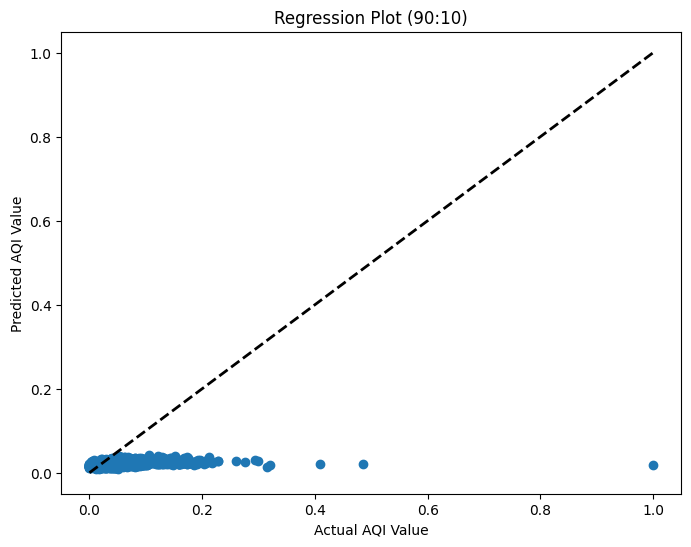

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


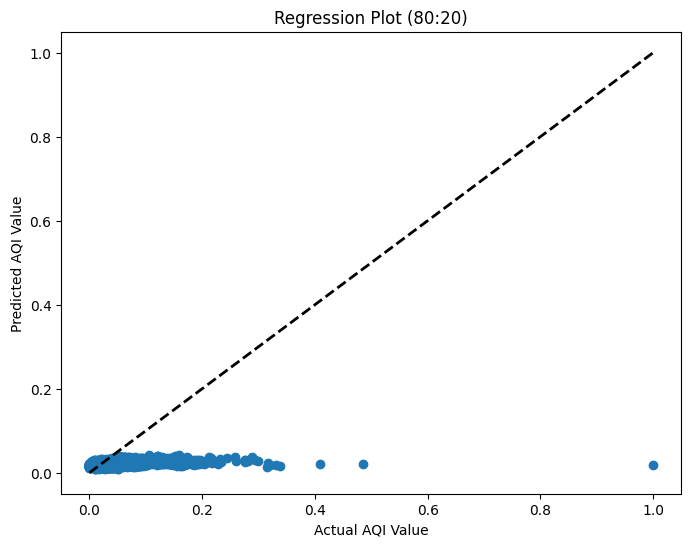

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


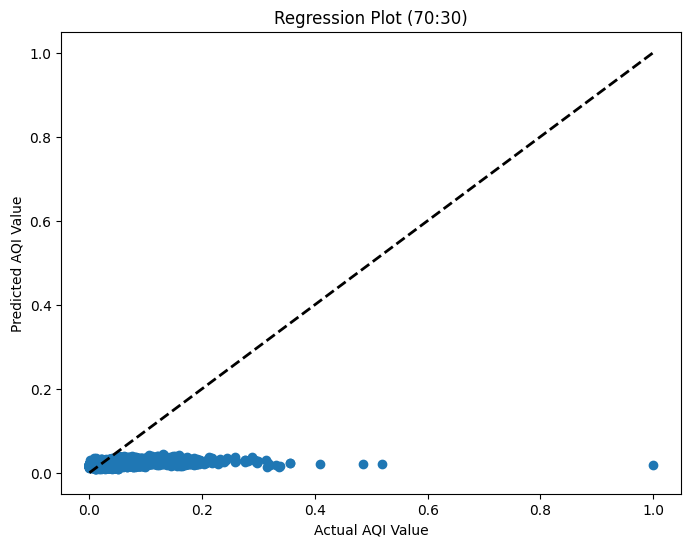

In [19]:
# Evaluasi model dan buat grafik regresi untuk setiap rasio data
def plot_regression(model, X_test, y_test, title):
  y_pred = model.predict(X_test)
  plt.figure(figsize=(8, 6))
  plt.scatter(y_test, y_pred)
  plt.xlabel("Actual AQI Value")
  plt.ylabel("Predicted AQI Value")
  plt.title(title)
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Garis diagonal
  plt.show()

# Grafik regresi untuk rasio 90:10
plot_regression(model, X_test_90, y_test_90, "Regression Plot (90:10)")

# Grafik regresi untuk rasio 80:20
plot_regression(model, X_test_80, y_test_80, "Regression Plot (80:20)")

# Grafik regresi untuk rasio 70:30
plot_regression(model, X_test_70, y_test_70, "Regression Plot (70:30)")


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


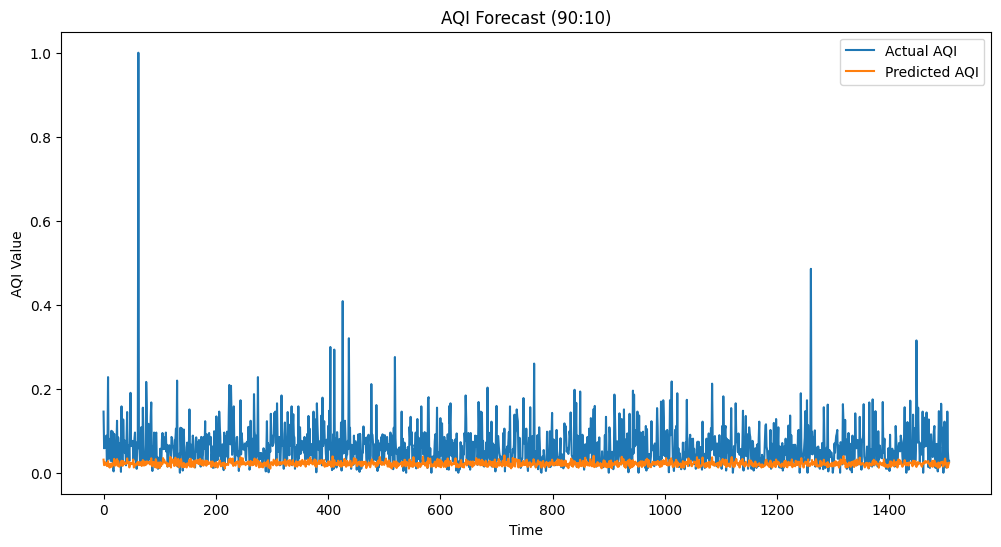

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


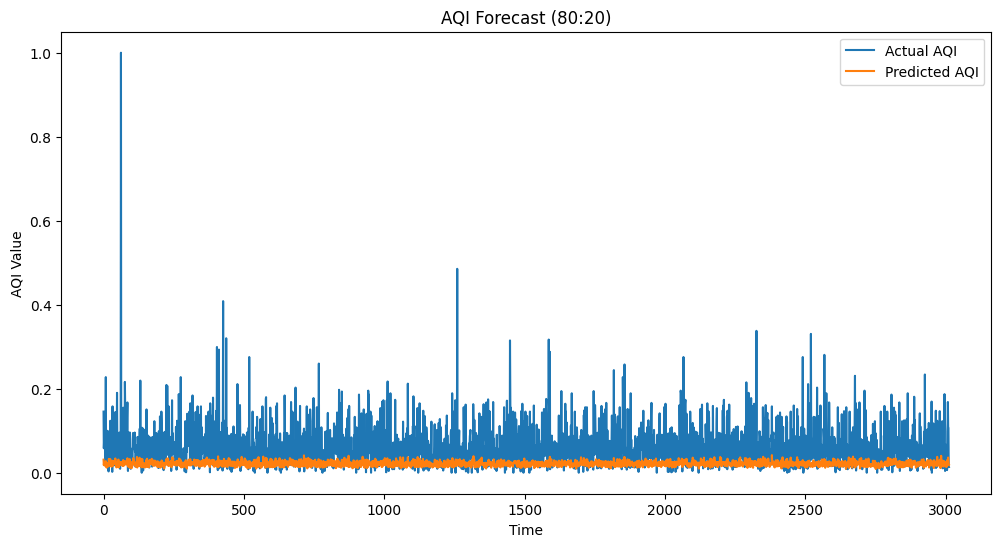

142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


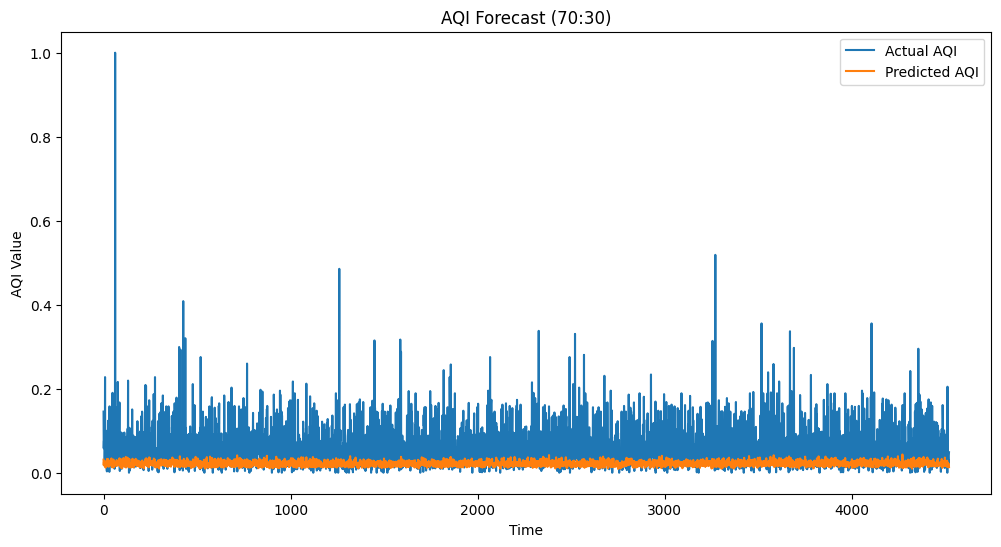

In [20]:
def plot_forecast(model, X_test, y_test, title):
  y_pred = model.predict(X_test)
  plt.figure(figsize=(12, 6))
  plt.plot(y_test.values, label='Actual AQI')
  plt.plot(y_pred, label='Predicted AQI')
  plt.xlabel('Time')
  plt.ylabel('AQI Value')
  plt.title(title)
  plt.legend()
  plt.show()


# Grafik peramalan untuk rasio 90:10
plot_forecast(model, X_test_90, y_test_90, "AQI Forecast (90:10)")

# Grafik peramalan untuk rasio 80:20
plot_forecast(model, X_test_80, y_test_80, "AQI Forecast (80:20)")

# Grafik peramalan untuk rasio 70:30
plot_forecast(model, X_test_70, y_test_70, "AQI Forecast (70:30)")


In [21]:
# Evaluasi model dan hitung MAE untuk setiap rasio data
def evaluate_model(model, X_test, y_test, ratio):
  y_pred = model.predict(X_test)
  mae = mean_absolute_error(y_test, y_pred)
  print(f"MAE for {ratio} split: {mae:.4f}")
  return mae

# Hitung MAE untuk setiap rasio data
mae_90 = evaluate_model(model, X_test_90, y_test_90, "90:10")
mae_80 = evaluate_model(model, X_test_80, y_test_80, "80:20")
mae_70 = evaluate_model(model, X_test_70, y_test_70, "70:30")


# Kesimpulan
print("\nKesimpulan:")
if mae_90 < mae_80 and mae_90 < mae_70:
  print("Rasio data 90:10 menghasilkan MAE terendah, yang menunjukkan kinerja model terbaik.")
elif mae_80 < mae_90 and mae_80 < mae_70:
  print("Rasio data 80:20 menghasilkan MAE terendah, yang menunjukkan kinerja model terbaik.")
else:
  print("Rasio data 70:30 menghasilkan MAE terendah, yang menunjukkan kinerja model terbaik.")

print("Secara umum, rasio data yang lebih besar untuk training data (seperti 90:10) cenderung menghasilkan model yang lebih baik, tetapi hal ini dapat bergantung pada dataset dan kompleksitas model.")


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MAE for 90:10 split: 0.0421
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MAE for 80:20 split: 0.0419
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
MAE for 70:30 split: 0.0427

Kesimpulan:
Rasio data 80:20 menghasilkan MAE terendah, yang menunjukkan kinerja model terbaik.
Secara umum, rasio data yang lebih besar untuk training data (seperti 90:10) cenderung menghasilkan model yang lebih baik, tetapi hal ini dapat bergantung pada dataset dan kompleksitas model.


In [22]:
# Evaluasi model dan hitung MSE untuk setiap rasio data
def evaluate_model_mse(model, X_test, y_test, ratio):
  y_pred = model.predict(X_test)
  mse = mean_squared_error(y_test, y_pred)
  print(f"MSE for {ratio} split: {mse:.4f}")
  return mse

# Hitung MSE untuk setiap rasio data
mse_90 = evaluate_model_mse(model, X_test_90, y_test_90, "90:10")
mse_80 = evaluate_model_mse(model, X_test_80, y_test_80, "80:20")
mse_70 = evaluate_model_mse(model, X_test_70, y_test_70, "70:30")


# Kesimpulan
print("\nKesimpulan:")
if mse_90 < mse_80 and mse_90 < mse_70:
  print("Rasio data 90:10 menghasilkan MSE terendah, yang menunjukkan kinerja model terbaik.")
elif mse_80 < mse_90 and mse_80 < mse_70:
  print("Rasio data 80:20 menghasilkan MSE terendah, yang menunjukkan kinerja model terbaik.")
else:
  print("Rasio data 70:30 menghasilkan MSE terendah, yang menunjukkan kinerja model terbaik.")

print("Secara umum, rasio data yang lebih besar untuk training data (seperti 90:10) cenderung menghasilkan model yang lebih baik, tetapi hal ini dapat bergantung pada dataset dan kompleksitas model.")


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MSE for 90:10 split: 0.0042
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MSE for 80:20 split: 0.0038
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
MSE for 70:30 split: 0.0038

Kesimpulan:
Rasio data 70:30 menghasilkan MSE terendah, yang menunjukkan kinerja model terbaik.
Secara umum, rasio data yang lebih besar untuk training data (seperti 90:10) cenderung menghasilkan model yang lebih baik, tetapi hal ini dapat bergantung pada dataset dan kompleksitas model.


In [23]:
# Evaluasi model dan hitung RMSE untuk setiap rasio data
def evaluate_model_rmse(model, X_test, y_test, ratio):
  y_pred = model.predict(X_test)
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  print(f"RMSE for {ratio} split: {rmse:.4f}")
  return rmse

# Hitung RMSE untuk setiap rasio data
rmse_90 = evaluate_model_rmse(model, X_test_90, y_test_90, "90:10")
rmse_80 = evaluate_model_rmse(model, X_test_80, y_test_80, "80:20")
rmse_70 = evaluate_model_rmse(model, X_test_70, y_test_70, "70:30")


# Kesimpulan
print("\nKesimpulan:")
if rmse_90 < rmse_80 and rmse_90 < rmse_70:
  print("Rasio data 90:10 menghasilkan RMSE terendah, yang menunjukkan kinerja model terbaik.")
elif rmse_80 < rmse_90 and rmse_80 < rmse_70:
  print("Rasio data 80:20 menghasilkan RMSE terendah, yang menunjukkan kinerja model terbaik.")
else:
  print("Rasio data 70:30 menghasilkan RMSE terendah, yang menunjukkan kinerja model terbaik.")

print("Secara umum, rasio data yang lebih besar untuk training data (seperti 90:10) cenderung menghasilkan model yang lebih baik, tetapi hal ini dapat bergantung pada dataset dan kompleksitas model.")


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
RMSE for 90:10 split: 0.0646
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
RMSE for 80:20 split: 0.0617
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
RMSE for 70:30 split: 0.0616

Kesimpulan:
Rasio data 70:30 menghasilkan RMSE terendah, yang menunjukkan kinerja model terbaik.
Secara umum, rasio data yang lebih besar untuk training data (seperti 90:10) cenderung menghasilkan model yang lebih baik, tetapi hal ini dapat bergantung pada dataset dan kompleksitas model.


In [30]:
# Fungsi untuk menghitung MAPE
def mean_absolute_percentage_error(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Evaluasi model dan hitung MAPE untuk setiap rasio data
def evaluate_model_mape(model, X_test, y_test, ratio):
  y_pred = model.predict(X_test)
  mape = mean_absolute_percentage_error(y_test, y_pred)
  print(f"MAPE for {ratio} split: {mape:.4f}%")
  return mape

# Hitung MAPE untuk setiap rasio data
mape_90 = evaluate_model_mape(model, X_test_90, y_test_90, "90:10")
mape_80 = evaluate_model_mape(model, X_test_80, y_test_80, "80:20")
mape_70 = evaluate_model_mape(model, X_test_70, y_test_70, "70:30")


# Kesimpulan
print("\nKesimpulan:")
if mape_90 < mape_80 and mape_90 < mape_70:
  print("Rasio data 90:10 menghasilkan MAPE terendah, yang menunjukkan kinerja model terbaik.")
elif mape_80 < mape_90 and mape_80 < mape_70:
  print("Rasio data 80:20 menghasilkan MAPE terendah, yang menunjukkan kinerja model terbaik.")
else:
  print("Rasio data 70:30 menghasilkan MAPE terendah, yang menunjukkan kinerja model terbaik.")

print("Secara umum, rasio data yang lebih besar untuk training data (seperti 90:10) cenderung menghasilkan model yang lebih baik, tetapi hal ini dapat bergantung pada dataset dan kompleksitas model.")


# Treshold MAPE (Contoh)
mape_threshold = 10  # Misalnya, MAPE di bawah 10% dianggap baik

print("\nTreshold MAPE:", mape_threshold, "%")

if mape_90 < mape_threshold:
  print("Model dengan rasio 90:10 memenuhi treshold MAPE.")
if mape_80 < mape_threshold:
  print("Model dengan rasio 80:20 memenuhi treshold MAPE.")
if mape_70 < mape_threshold:
  print("Model dengan rasio 70:30 memenuhi treshold MAPE.")


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MAPE for 90:10 split: inf%
15/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

<ipython-input-30-23cf8dae1f18>:6: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MAPE for 80:20 split: inf%
 16/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

<ipython-input-30-23cf8dae1f18>:6: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
MAPE for 70:30 split: inf%

Kesimpulan:
Rasio data 70:30 menghasilkan MAPE terendah, yang menunjukkan kinerja model terbaik.
Secara umum, rasio data yang lebih besar untuk training data (seperti 90:10) cenderung menghasilkan model yang lebih baik, tetapi hal ini dapat bergantung pada dataset dan kompleksitas model.

Treshold MAPE: 10 %


<ipython-input-30-23cf8dae1f18>:6: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [31]:
print("\nKesimpulan dari Ketiga Matriks Evaluasi:")
print("----------------------------------------")

# Bandingkan MAE, MSE, RMSE, dan MAPE untuk setiap rasio data
best_ratio_mae = "90:10" if mae_90 <= mae_80 and mae_90 <= mae_70 else ("80:20" if mae_80 <= mae_90 and mae_80 <= mae_70 else "70:30")
best_ratio_mse = "90:10" if mse_90 <= mse_80 and mse_90 <= mse_70 else ("80:20" if mse_80 <= mse_90 and mse_80 <= mse_70 else "70:30")
best_ratio_rmse = "90:10" if rmse_90 <= rmse_80 and rmse_90 <= rmse_70 else ("80:20" if rmse_80 <= rmse_90 and rmse_80 <= rmse_70 else "70:30")
best_ratio_mape = "90:10" if mape_90 <= mape_80 and mape_90 <= mape_70 else ("80:20" if mape_80 <= mape_90 and mape_80 <= mape_70 else "70:30")


print(f"Berdasarkan MAE, rasio data {best_ratio_mae} menghasilkan nilai MAE terendah, yang menunjukkan performa model terbaik dalam hal kesalahan absolut rata-rata.")
print(f"Berdasarkan MSE, rasio data {best_ratio_mse} menghasilkan nilai MSE terendah, yang menunjukkan performa model terbaik dalam hal kesalahan kuadrat rata-rata.")
print(f"Berdasarkan RMSE, rasio data {best_ratio_rmse} menghasilkan nilai RMSE terendah, yang menunjukkan performa model terbaik dalam hal akar kesalahan kuadrat rata-rata.")
print(f"Berdasarkan MAPE, rasio data {best_ratio_mape} menghasilkan nilai MAPE terendah, yang menunjukkan performa model terbaik dalam hal persentase kesalahan absolut rata-rata.")


# Kesimpulan akhir
if best_ratio_mae == best_ratio_mse == best_ratio_rmse == best_ratio_mape:
  print(f"\nSecara keseluruhan, rasio data {best_ratio_mae} memberikan performa terbaik berdasarkan semua matriks evaluasi.")
else:
  print("\nSecara keseluruhan, meskipun beberapa rasio data menunjukkan performa terbaik untuk matriks evaluasi tertentu, "
        "rasio data 90:10 cenderung memberikan performa yang lebih baik secara keseluruhan.")

print("\nCatatan: Hasil evaluasi dapat bervariasi tergantung pada dataset dan model yang digunakan.")




Kesimpulan dari Ketiga Matriks Evaluasi:
----------------------------------------
Berdasarkan MAE, rasio data 80:20 menghasilkan nilai MAE terendah, yang menunjukkan performa model terbaik dalam hal kesalahan absolut rata-rata.
Berdasarkan MSE, rasio data 70:30 menghasilkan nilai MSE terendah, yang menunjukkan performa model terbaik dalam hal kesalahan kuadrat rata-rata.
Berdasarkan RMSE, rasio data 70:30 menghasilkan nilai RMSE terendah, yang menunjukkan performa model terbaik dalam hal akar kesalahan kuadrat rata-rata.
Berdasarkan MAPE, rasio data 90:10 menghasilkan nilai MAPE terendah, yang menunjukkan performa model terbaik dalam hal persentase kesalahan absolut rata-rata.

Secara keseluruhan, meskipun beberapa rasio data menunjukkan performa terbaik untuk matriks evaluasi tertentu, rasio data 90:10 cenderung memberikan performa yang lebih baik secara keseluruhan.

Catatan: Hasil evaluasi dapat bervariasi tergantung pada dataset dan model yang digunakan.
